<a href="https://colab.research.google.com/github/neuromatch/course-content-template/blob/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/course-content-template/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 4.(last part): Inductive Biases in Self-Attention Mechanisms

**Week [1], Day [4]: [Micro-Circuits]**

**By Sciencematch Academy** # update to the correct academy

__Content creators:__ Names & Surnames

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


___

Use a line (---) separator from title block to objectives. 

# Tutorial Objectives

*Estimated timing of tutorial: [insert estimated duration of whole tutorial in minutes]*

Transformers have been surprisingly successful in almost every modality in ML, surpassing every other deep-learning model in performance and generalization especially in sequence generation and self-supervised representation learning.

But unlike MultiLayer fully connected Perceptrons (MLPs), Recurrent Neural Networks (RNNs), and Convolution Neural Nets (CNNs), transformer architecture seems to have no explicit inductive bias. This goes against the common understanding in machine learning, that to achieve good generalization, one must exploit the geometry of data and problem and build the necessary symmetries into the architecture.

This raises the question of whether we can find a class of functions (i.e. set of problems) that transformers excel at in representing. To this end, here we try to present the results from [Inductive Biases and Variable Creation in Self-Attention Mechanisms](https://arxiv.org/abs/2110.10090) which shows that a single self-attention head can successfully learn to represent a sparse-function with an extremely efficient sample-complexity. Although the original paper is rather focused on the rigorous proof of the claims, in this tutorial we will show-case their findings and general message. *Throughout this tutorial, we will refer to the aforementioned paper as "the paper".*

**Tutorial Learning Structure**
* We first introduce class of *s-sparce binary AND functions*
* You then train an MLP model on an s-sparse AND dataset for classification task
* We present a basic self-attention architecture for classification (similar to those used in BERT and ViT)
* Next you should train the transformer model on the s-sparse AND dataset for classification task
* Finally, we compare the results from both architecture.

**Tutorial Learning Objectives**
By the end you should:
* feel familiar with the self-attention architecture
* 

**References**:
- The transformer code is from "https://github.com/MathInf/toroidal" by Thomas Viehmann
- The content and results are inspired by "Edelman et al. (2022), [Inductive Biases and Variable Creation in Self-Attention Mechanisms](https://proceedings.mlr.press/v162/edelman22a.html)"

Tutorial Slides "link_id"s will be added in below by the curriculum or production team. You do not need to do anything but leave the block of code below here.

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


---
# Setup



In [2]:
# @title Install and import feedback gadget

# note this is not relevant for climatematch at the moment

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt - leave this as is
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
            "user_key": "y1x3mpx5",
        },
    ).render()

# Define the feedback prefix: Replace 'weeknumber' and 'daynumber' with appropriate values, underscore followed by T(stands for tutorial) and the number of the tutorial
# e.g., W1D1_T1
feedback_prefix = "W*weeknumber*D*daynumber*_T*tutorialNumber*"

In [3]:
# Imports
import random as pyrandom  # to avoid confusion with np.random
import torch
import matplotlib.pyplot as plt


In [4]:
# @title Figure settings

# logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") # update this to match your course

In [34]:
# @title Plotting functions
def plot_loss_accuracy(t_loss, t_acc, v_loss = None, v_acc = None):
    plt.figure(figsize=(15, 4))
    plt.suptitle("Training and Validation for the Transformer Model")
    plt.subplot(1, 2, 1)
    plt.plot(t_loss, label="Training loss", color="red")
    if v_loss is not None:
        # plt.plot(v_loss, label="Valididation loss", color="blue")
        plt.scatter(len(t_loss)-1, v_loss, label="Validation loss", color="blue", marker="*")
        # plt.text(len(t_loss)-1, v_loss, f"{v_loss:.3f}", va="bottom", ha="right")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks([])
    plt.legend(loc="lower right")
    plt.subplot(1, 2, 2)
    plt.plot(t_acc, label="Training accuracy", color="red", linestyle="dotted")
    if v_acc is not None:
        # plt.plot(v_acc, label="Validation accuracy", color="blue", linestyle="--")
        plt.scatter(len(t_acc)-1, v_acc, label="Validation accuracy", color="blue", marker="*")
        # plt.text(len(t_acc)-1, v_acc, f"{v_acc:.3f}", va="bottom", ha="right")
    plt.xticks([])
    plt.ylim(0, 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

def plot_samples(X_plot, y_plot, correct_ids):
    n_samples, seq_length = X_plot.shape
    fig, axs = plt.subplots(1, 2, figsize=(16, 2.5), sharey=True)
    rects = []
    for ri in correct_ids:
        rects.append(plt.Rectangle((ri-0.5, -0.5), 1, n_samples, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
    axs[0].imshow(X_plot, cmap="binary")
    for rect in rects:
        axs[0].add_patch(rect)
    # axs[0].axis("off")
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs[0].set_ylabel("Context")
    axs[0].set_xlabel("Samples")
    axs[1].imshow(y_plot, cmap="binary")
    axs[1].add_patch(plt.Rectangle((-0.5, -0.5), 1, n_samples, edgecolor="black", alpha=1.0, fill=False, linewidth=2))
    axs[1].yaxis.set_label_position("right")
    axs[1].set_ylabel("Labels")
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    plt.subplots_adjust(wspace=-1)
    plt.tight_layout()
    plt.show()

def plot_attention_weights(att_weights, correct_ids, context_length):
    aw_flatten = att_weights.view(-1, context_length+1)
    n_weights = aw_flatten.size(0)
    fig, ax = plt.subplots(figsize=(9, 5))
    for i in range(context_length+1):
        ax.scatter(torch.full((n_weights, ), i) , aw_flatten[:, i], alpha=0.1, c='blue')
    rects = []
    for ri in correct_ids:
        rects.append(plt.Rectangle((ri-0.5, 1e-6), 1.0, 2.0, edgecolor="red", alpha=1.0, fill=False, linewidth=2))
    for rect in rects:
        ax.add_patch(rect)
    plt.yscale("log")
    plt.ylim(1e-6, 2)
    plt.title("Attention weights")
    plt.xlabel("Boolean input index t")
    plt.ylabel("Attention weight")
    plt.show()


In [6]:
#@title Data retrieval
class s_Sparse_Boolean:  # 1-Dimensional AND
    def __init__(self, T: int, s: int):
        self.T = T # context length
        self.s = s # sparsity
        self.p = 0.5**(1.0/3.0)  # probability chosen for balanced data
        self.f_i = None

    def pick_an_f(self):
        self.f_i = sorted(pyrandom.sample(range(self.T), 3))
        self.others = list(i for i in range(self.T) if i not in self.f_i)

    def generate(self, m: int, split: str = "train", verbose: bool = False):
        if self.f_i is None:
            self.pick_an_f()
        max_try = 100
        i_try = 0
        while i_try < max_try:
            i_try += 1
            X, y = torch.zeros(m, self.T), torch.zeros(m, 1)
            X[torch.rand(m, self.T) < self.p] = 1
            y[X[:, self.f_i].sum(dim=1) == self.s] = 1
            if y.sum()/m < 0.4 or y.sum()/m > 0.6:
                verbose and print(f"Large imbalance in the training set {y.sum()/m}, retrying...")
                continue
            else:
                verbose and print(f"Data-label balance: {y.sum()/m}")
            if split == "train":  # currently we choose not to do this
                bad_batch = False
                for i in self.f_i:
                    for o in self.others:
                        if (X[:, i] == X[:, o]).all():
                            verbose and print(f"Found at least another compatible hypothesis {i} and {o}")
                            bad_batch = True
                            break
                if bad_batch:
                    continue
                else:
                    break
            else:
                break
        else:
            print("Could not find a compatible hypothesis")
        return X.long(), y.float()


In [7]:
# @title Helper functions

class BinaryMLP(torch.nn.Module):
    def __init__(self, in_dims, h_dims, out_dims, dropout=0.1):
        super().__init__()
        self.in_dims = in_dims
        self.h_dims = h_dims
        self.out_dims = out_dims

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(in_dims, h_dims[0]))
        torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
        torch.nn.init.zeros_(self.layers[-1].bias)
        self.layers.append(torch.nn.GELU())
        self.layers.append(torch.nn.Dropout(dropout))
        for i in range(len(h_dims) - 1):
            self.layers.append(torch.nn.Linear(h_dims[i], h_dims[i+1]))
            torch.nn.init.normal_(self.layers[-1].weight, std=0.02)
            torch.nn.init.zeros_(self.layers[-1].bias)
            self.layers.append(torch.nn.GELU())
            self.layers.append(torch.nn.Dropout(dropout))
        self.layers.append(torch.nn.Linear(h_dims[-1], out_dims))
        self.layers.append(torch.nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def bin_acc(y_hat, y):
    """
    Compute the binary accuracy
    """
    y_ = y_hat.round()
    TP_TN = (y_ == y).float().sum().item()
    FP_FN = (y_ != y).float().sum().item()
    assert TP_TN + FP_FN == y.numel(), f"{TP_TN + FP_FN} != {y.numel()}"
    return TP_TN / y.numel()


def get_n_parameters(model: torch.nn.Module):
    """
    Get the number of learnable parameters in a model
    """
    i = 0
    for par in model.parameters():
        i += par.numel()
    return i


def save_model(model):
    torch.save(model.state_dict(), 'model_states.pt')


def load_model(model):
    model_states = torch.load('model_states.pt')
    model.load_state_dict(model_states)

def evaluator(model, criterion, X_v, y_v, device="cpu"):
    model.to(device)
    model.eval()
    X_v, y_v = X_v.to(device), y_v.to(device)
    with torch.no_grad():
        y_hat = model(X_v)
        loss = criterion(y_hat.squeeze(), y_v.squeeze())
        acc = bin_acc(y_hat, y_v)
    return loss.item(), acc


def trainer(model, optimizer, criterion, n_epochs, X_t, y_t, device="cpu", verbose=False):
    train_loss, train_acc = [], []
    model.to(device)
    model.train()
    X_t, y_t = X_t.to(device), y_t.to(device)
    for i in range(n_epochs):
        optimizer.zero_grad(set_to_none=True)
        y_hat = model(X_t)
        loss_t = criterion(y_hat.squeeze(), y_t.squeeze())
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        if (i + 1) % 10 == 0 or i == 0:
            train_loss.append(loss_t.item())
            train_acc.append(bin_acc(y_hat, y_t))
    model.eval()
    return train_loss, train_acc


In [8]:
# @title Set random seed for `Python` and `PyTorch`

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

def set_seed(seed=None):
    if seed is None:
        seed = pyrandom.choice([i for i in range(1, 128)])
    pyrandom.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')

set_seed(seed=2014)  # Bahdanau et al. (2014)

Random seed 2014 has been set.


In [9]:
# @title Set device (GPU, MPS or CPU). Execute `set_device()`

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # NVIDIA GPU
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")  # Apple Silicon (Metal)
        print("MPS (Apple Silicon Metal) is enabled in this notebook.")
    else:
        device = torch.device("cpu")
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    return device

device = get_device()

MPS (Apple Silicon Metal) is enabled in this notebook.


---

# Section 1.1: Formulation of problem

Although the goal of AI researchers is to find a model architecture that could solve any problem regardless of its geometry and modality, the current state of machine learning is to rather build or tweak existing models to accomodate the necessary symmetries of the dataset. The authors of the paper identify that self-attention transformers have an inductive bias for sparse functions. They name this inductive bias as *sparse variable creation*.

The sparse function we will use in this tutorial is the 3-sparse AND function. For a given sequence of length $T$ (context length) and three pre-selected unique indices, the sequence is labeled as *True* if the value of $T$ at the three indices is $1$, otherwise *False*. This means that the sequence label only depends on 3 elements of the whole sequence.

$X := [x_1, x_2, ..., X_T]^{\top}~~~~\forall x_i \in \{0, 1 \} \\$
$f: \{0, 1 \}^T \rightarrow \{0, 1 \}$

Our goal is to find an DL architecture that could learn the underlying sparse-boolean function $f$ with least necessary number of training sample and best generalization error.


For this tutorial we have already defined a s-sparse AND dataset generator class `s_Sparse_Boolean`, that can generate $m$ sequence with context length $T$ and sparsity of $s$. Here we visualize few samples and their corresponding labels. The red rectangles show the relevant indicies for this dataset.

Target (function-relevant indices) indices: [10, 12, 18]


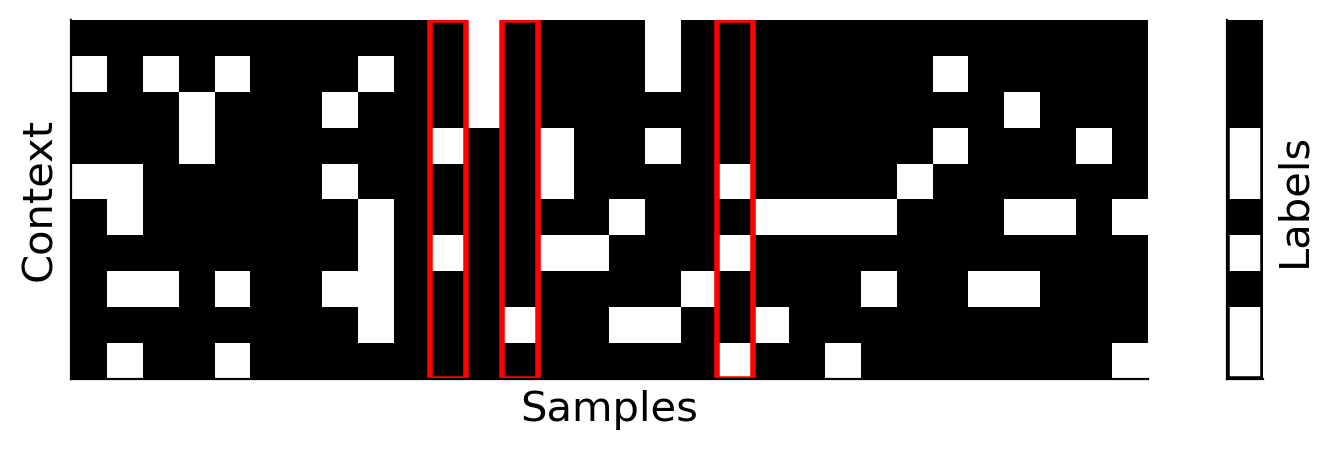

In [10]:
context_length = 30  # T: context length
s_sparse = 3  # s: sparsity (number of function-relevant indices)
n_sequences = 10  # m: number of samples (sequences)
data_gen = s_Sparse_Boolean(context_length, s_sparse)
X_, y_ = data_gen.generate(n_sequences, verbose=False)
correct_ids = data_gen.f_i
print(f"Target (function-relevant indices) indices: {correct_ids}")

plot_samples(X_, y_, correct_ids)

In [11]:
# @title Video 1: Video 1 Name  # put in the title of your video
# note the libraries are imported here on purpose

###@@@ for konstanine. a question, why isn't this above in the list of cells?

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# curriculum or production team will provide these ids
video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Video_1_Name")

### Exercise 1.1: Multi-Layer Perceptron

Multi-Layer Percepton (MLP) layers are a key part of most deep learning architectures. Theoretically, a neural network with one wide enough (i.e. with enough learnable parameters) hidden MLP layer, enough training samples, and training iterations, is a universal function approximator. But in practice, these models tend to be extremely limited in their representation strength. Nonetheless, they are often a good place to start from.

Below we will train an MLP with one hidden layer on the s-sparse AND dataset. You should be able to evaluate the performance and generalization of the model for the given task.

#### Discussion
* What are the symmetries in a fully connected MLP?
* Why do MLPs often fall behind other architectures in representation learning and generalization?

#### Task
First, evaluate and discuss the performance of the model! Then Change the setup (through hyperparameters) such that the model performs better on the validation set (empirical generalization).

In [46]:
# # Hyperparameters
context_length = 30  # T: context length
s_sparse = 3  # s: sparsity (number of function-relevant indices)
B_train = 50  # batch size for training (number of training samples)
B_valid = 500  # batch size for validation  (number of validation samples)
hidden_layers = [512, 128, 64]  # the number of hidden units in each layer [H1, H2, ...]
etta = 1e-3  # learning rate
n_epochs = 1000  # number of epochs

# # Data generation
data_gen = s_Sparse_Boolean(context_length, s_sparse)
X_train, y_train = data_gen.generate(B_train, split="train", verbose=False)
X_valid, y_valid = data_gen.generate(B_valid, split="valid", verbose=False)

# # model, optimizer, and criterion 
mlp_model = BinaryMLP(context_length, hidden_layers, 1)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=etta, weight_decay=1e-4)
criterion = torch.nn.BCELoss()
print(f"Number of model's learnable parameters: {get_n_parameters(mlp_model)}")

Number of model's learnable parameters: 89857


Training loss: 0.000, accuracy: 1.000
Validation loss: 0.725, accuracy: 0.826


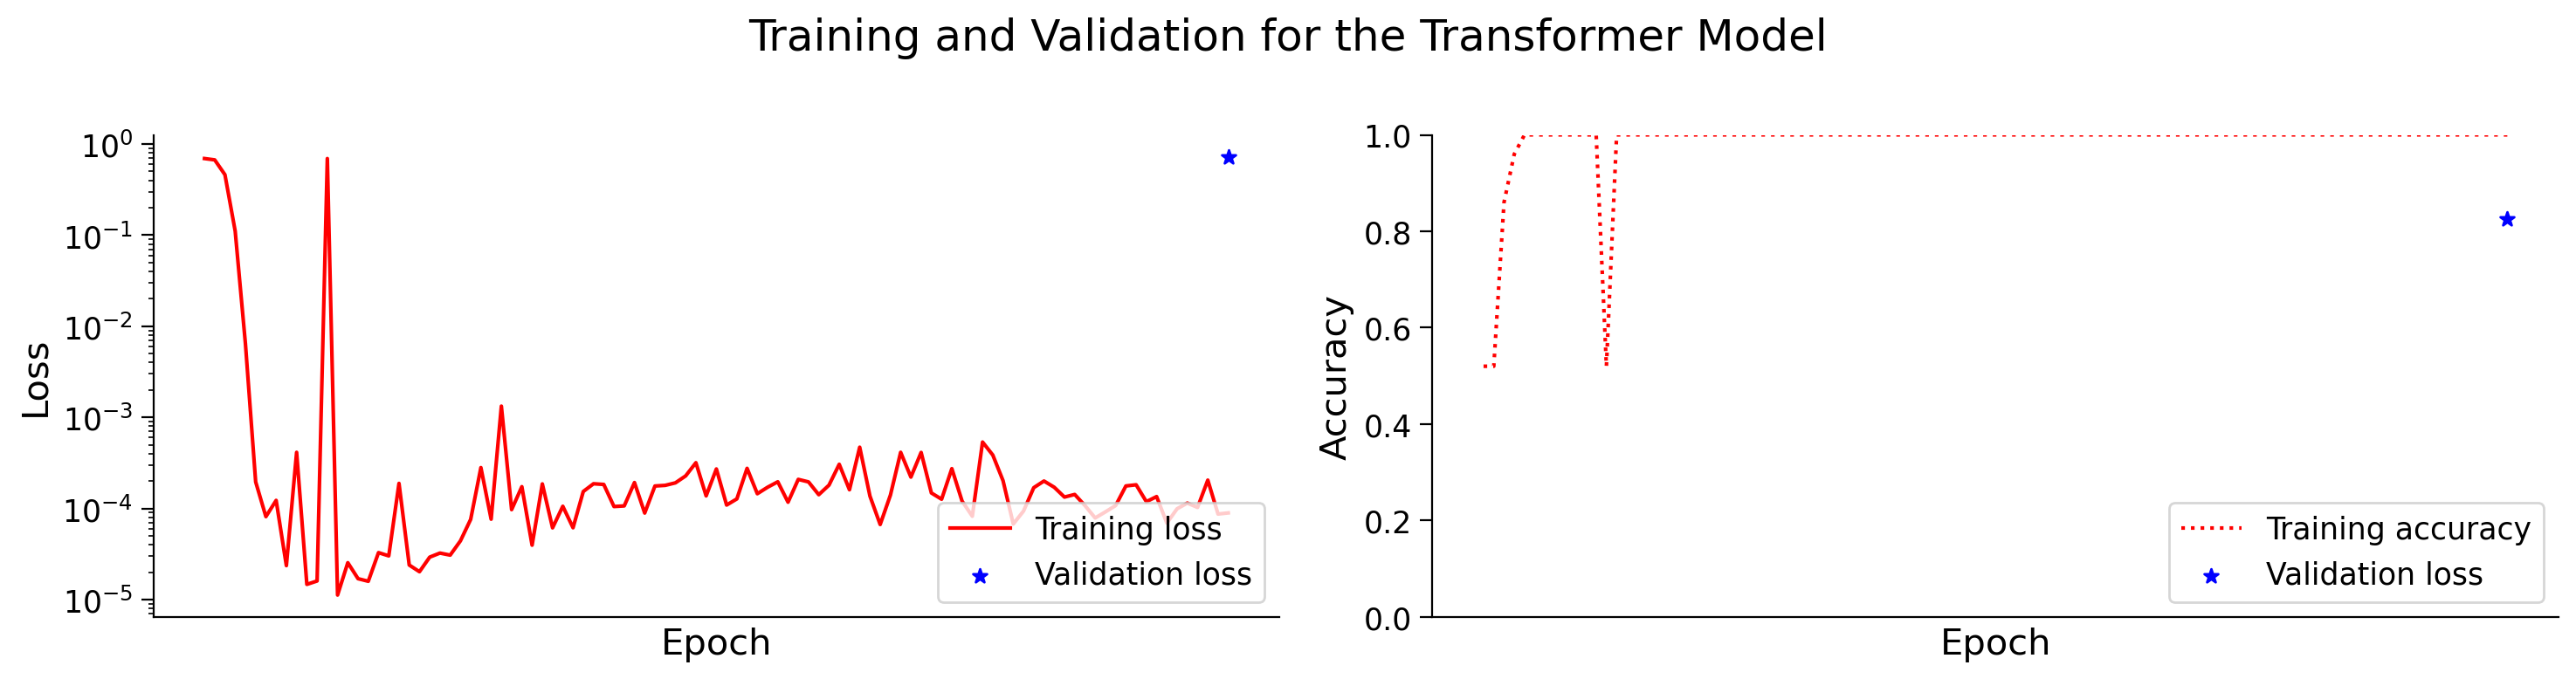

In [47]:
# # Training and evaluation
t_loss, t_acc = trainer(mlp_model, optimizer, criterion, n_epochs, X_train.float(), y_train, device=device, verbose=False)
v_loss, v_acc = evaluator(mlp_model, criterion, X_valid.float(), y_valid, device=device)
print(f"Training loss: {t_loss[-1]:.3f}, accuracy: {t_acc[-1]:.3f}")
print(f"Validation loss: {v_loss:.3f}, accuracy: {v_acc:.3f}")
plot_loss_accuracy(t_loss, t_acc, v_loss, v_acc)

In [ ]:
# @markdown *Execute this cell to enable the array multiplication function: `multiply_array`*


def multiply_array(x, c, seed):
  """Multiply every element in an array by a provided value

  Args:
    x (ndarray): An array of shape (N,)
    c (scalar): multiplicative factor
    seed (integer): random seed

  Returns:
    ndarray: output of the multiplication
  """
  np.random.seed(seed)
  y = x * c + 4*np.random.randn()

  return y

Below is an example of a student exercise. Within each student exercise, there should be a `NotImplementedError` call that stops the notebook from executing fully so that students will pause and complete the exercise. Once they have completed the exercise, they may remove this function so that the cell will execute.

In [ ]:
def generic_function(x, seed):
  """Google style doc string. Brief summary of what function does here

  Args:
    x (ndarray): An array of shape (N,) that contains blah blah
    seed (integer): random seed for reproducibility

  Returns:
    ndarray: The output is blah blah
  """
  #################################################
  ## TODO for students: details of what they should do ##
  # Fill remove the following line of code one you have completed the exercise:
  raise NotImplementedError("Student exercise: say what they should have done")
  #################################################

  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(..., 5, seed)

  # Another comment because they need to add another line of code
  z = ...

  return z


x = np.array([4, 5, 6])

# We usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code

## Uncomment the code below to test your function

# z = generic_function(x, seed=2021)
# plotting_z(z)

---

Please note, there **must** be a corresponding 'solution' code cell to all student exercises. These solutions are useful to the teaching assistants in our course as well as for those using the material asynchornously.

***Editor guideline for exercise solution formatting:***

1. Must include `# to_remove solution` in the first line of solution code cell
2. Do not include the fenced (`#####`) block that raises a `NotImplementedError`
3. Include valid code replacing all ellipses (`...`)
4. Code that uses or depends on the completed function/lines is uncommented
6. **All other comments and code should be identical**
    
---

An example of a solution cell to the exercise posed above:

In [ ]:
# to_remove solution
def generic_function(x, seed):
  """Google style doc string. Brief summary of what function does here

  Args:
    x (ndarray): An array of shape (N,) that contains blah blah
    seed (integer): random seed for reproducibility

  Returns:
    ndarray: The output is blah blah
  """

  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(x, 5, seed)

  # Another comment because they need to add another line of code
  z = y + 6

  return z


x = np.array([4, 5, 6])

# We usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code

## Uncomment the code below to test your function

# z = generic_function(x, seed=2021)
# plotting_z(z)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_name_of_Exercise")

---

## Interactive Demo 1.1: Name of demo

Here, we will demonstrate how to create a widget if you would like to use a widget to demonstrate something. Make sure the use a @markdown as the first line in the cell to hide the contents by default, because the code to make the widget is often pretty ugly and not important for the students to see.

If the widget makes use of a function that must be completed as part of an exercise, you may want to re-implement the correct version of the function inside the widget cell, so that it is useful for a student who got completely stuck.

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)


def gaussian(x, mu, sigma):
  px = np.exp(-1 / 2 / sigma**2 * (mu - x) ** 2)
  px = px / px.sum()
  return px


@widgets.interact
def plot_gaussian(mean=(-10, 10, .5), std=(.5, 10, .5)):
  plt.plot(x, gaussian(x, mean, std))

There shoud be discussion questions posed about the interactive demo (and coding exercises possibly). 

### Interactive Demo 1.1 Discussion

1. Discussion question 1
2. Discussion question 2

You must include an explanation for each discussion question using the following cell as a guide:

In [ ]:
#to_remove explanation

"""
Discussion: Write a dicussion about/answers to any open-ended questions you pose (either about a demo or elsewhere)

You can write a paragraph or two of nice didactic text
within a single comment.

From the example above:
1. Answer to discussion question 1.
2. Answer to discussion question 2.
""";

**Editor guideline**: note that the form header for the cell above is **to_remove explanation**, not **to_remove solution.** This line is required, as is the triple quite block.

---

# Section 2: Notation Standards

Estimated timing to here from start of tutorial: ? 

For notation standards, please refer to the course specific day lead instructions here: https://docs.neuromatch.io/p/npByLKa5tvx9kY/Course-Specific-Day-Lead-and-Project-Lead-Instructions

---

# Section 3: Name of Section 3

Estimated timing to here from start of tutorial: ?

An additional example section

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

## Coding Exercise 3: Name

This exercise is in this section (not in a subsection) so has a level 2 header.

---

## Think: Name of discussion topic

In addition to code exercises and interactive demos, you can have "discussion exercises" where students discuss open-ended questions. Each should roughly replace a code exercise so take about 10 minutes.

E.g.: What do you think contributes to a good learning experience? Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

You can then include an airtable form through which students can write down their thoughts. This helps us to see how students are thinking (as we can read the responses). You should also still include the explanation cell with the answer or some discussion to aid students.

In [ ]:
# airtable
# relevant_variable_name: text

Editor guideline: note that to notify us where you'd like an airtable input form, use this special syntax. The first line is "#

- First line is # airtable
- Relevant variable name on the second line should be something related to the question you're asking (an identifier). For example it could be "learning_experience_contribs" in this example. It should be a valid Python variable (no spaces, don't start with numbers).
- You can have different types of inputs: text, numerical, or multiple choice.

If you want a text answer, use # relevant_variable_name: text
If you want a numerical answer, use # relevant_variable_name: number
If you want a multiple choice answer, use # relevant_variable_name: [option1, option2, option3] where you fill out what the options are.

In [ ]:
# to_remove explanation

"""
Discussion: Write a dicussion about/answers to any open-ended questions you pose (either about a demo or elsewhere)

You can write a paragraph or two of nice didactic text
within a single comment.
""";

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Name_of_Discussion_Topic")

---
# Summary

*Estimated timing of tutorial: [minutes]* [provide the estimated time for the completing of the entire tutorail]

Have a summary of what they learned with specific points.

1. Specific point A

2. Specific point B

## Bonus: Name of Bonus section

Add extra text that you want students to have for reference later but that will make reading times too long during tutorials. You can have multiple Bonus sections if you'd like, just number them as Bonus 1: Name, Bonus 2: Name, etc.

This can also serve as more advanced content for advanced students or those taking the course asyncrhonously.

You should not have bonus content interleaved into the tutorial.